### Santender Bank 거래 예측 경진대회
1. 대회 개요
    - 목표: 고객이 미래에 특정 거래를 할지 여부를 예측 (이진 분류 문제).
    - 문제 배경: 
        Santander Bank는 고객의 금융 건강을 이해하고, 적합한 금융 상품 및 서비스를 제안하기 위해 머신러닝 알고리즘을 개선하려고 합니다. 이 대회는 고객의 특정 거래 여부를 예측하는 데 초점을 맞추고 있으며, 거래 금액과는 무관합니다.
    - 데이터 제공: 
        익명화된 데이터로, 각 행은 200개의 수치형 변수를 포함합니다. 변수에 대한 설명은 제공되지 않으며, 단순히 숫자로 식별됩니다.
    - 평가 지표: 
        ROC-AUC (Receiver Operating Characteristic - Area Under Curve). 예측 확률과 실제 타겟 간의 ROC 곡선 아래 면적을 기준으로 모델 성능을 평가합니다.
2. 데이터셋 분석
    - 데이터 구조:
        - 훈련 데이터: 200,000개의 고객 데이터, 각 행은 200개의 익명화된 수치형 피처로 구성.
        - 테스트 데이터: 200,000개의 고객 데이터, 동일한 200개의 피처로 구성.
        - 타겟 변수: 이진 변수 (0 또는 1)로, 고객이 특정 거래를 할지 여부를 나타냄.
        - 특이점: 데이터에 결측값이 없으며, 모든 피처는 독립적인 것으로 간주됩니다
        - 합성 데이터: 테스트 데이터셋에는 "가짜" 또는 합성 데이터가 포함되어 있으며, 이를 식별하는 것이 높은 점수를 얻는 데 중요한 요소로 나타났습니다.
    - 데이터 특징:
        피처는 익명화되어 있어 도메인 지식 없이 분석해야 하며, 이는 피처 엔지니어링의 중요성을 강조합니다.
        데이터는 불균형(imbalanced)한 특성을 가질 가능성이 있으며, 이를 해결하기 위해 오버샘플링과 같은 데이터 증강 기법이 사용되었습니다.

        특정 "마법의 피처(magic feature)"를 생성하면 ROC-AUC 점수가 0.90 이상으로 크게 향상될 수 있다는 점이 커뮤니티에서 논의되었습니다. 예를 들어, 행별 고유값 수를 활용해 합성 데이터를 식별하는 방법이 효과적이었습니다.

In [1]:
import os
print(os.getcwd())
print(os.listdir())

d:\workspace\hit_ml_dl\practice
['data', 'data_dictionary.png', 'heart.ipynb', 'heart_optuna.ipynb', 'linear_regression', 'mushroom.ipynb', 'santander.ipynb', 'stroke.ipynb', 'stroke_fixed.py', 'titanic.ipynb']


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

In [ ]:
# 데이터 로드
train_data = pd.read_csv("./data/santander/train.csv", encoding='utf-8')
test_data = pd.read_csv("./data/santander/test.csv", encoding='utf-8')
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB
None


In [8]:
print(train_data.head())

   ID_code  target    var_0   var_1  ...  var_196  var_197  var_198  var_199
0  train_0       0   8.9255 -6.7863  ...   7.8784   8.5635  12.7803  -1.0914
1  train_1       0  11.5006 -4.1473  ...   8.1267   8.7889  18.3560   1.9518
2  train_2       0   8.6093 -2.7457  ...  -6.5213   8.2675  14.7222   0.3965
3  train_3       0  11.0604 -2.1518  ...  -2.9275  10.2922  17.9697  -8.9996
4  train_4       0   9.8369 -1.4834  ...   3.9267   9.5031  17.9974  -8.8104

[5 rows x 202 columns]


In [9]:
print(test_data.head())

  ID_code    var_0    var_1    var_2  ...  var_196  var_197  var_198  var_199
0  test_0  11.0656   7.7798  12.9536  ...   4.3654  10.7200  15.4722  -8.7197
1  test_1   8.5304   1.2543  11.3047  ...  -1.4852   9.8714  19.1293 -20.9760
2  test_2   5.4827 -10.3581  10.1407  ...  -7.1086   7.0618  19.8956 -23.1794
3  test_3   8.5374  -1.3222  12.0220  ...   3.9567   9.2295  13.0168  -4.2108
4  test_4  11.7058  -0.1327  14.1295  ...  -5.1612   7.2882  13.9260  -9.1846

[5 rows x 201 columns]


In [10]:
# 결측값 확인
print("결측값 확인:\n", train_data.isnull().sum()) # 결측값 없음 확인

결측값 확인:
 ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64


In [12]:
# 피처와 타겟 분리
X = train_data.drop(columns=['ID_code', 'target'], axis=1)
y = train_data['target']
X_test = test_data.drop(columns=['ID_code'], axis=1)

In [13]:
# 3. 피처 스케일링 (GaussianNB에 유리하도록 표준화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [14]:
# 4. 간단한 피처 엔지니어링: 행별 고유값 수 계산 (합성 데이터 식별에 도움)
X['unique_count'] = X.nunique(axis=1)
X_test['unique_count'] = X_test.nunique(axis=1)

In [15]:
# 데이터 분할 (훈련/검증)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# 모델 설계 및 학습
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [17]:
# 예측 및 평가
y_pred_proba = model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"ROC-AUC 점수: {roc_auc:.4f}")

ROC-AUC 점수: 0.8882


In [ ]:
# 피처 중요도 계산 (퍼뮤테이션 중요도)
# 머신러닝 모델에서 각 피처의 중요도를 평가하는 방법
# 특정 피처의 값을 무작위로 섞었을 때 모델 성능이 얼마나 저하되는지를 측정
# 피처의 기여도를 추정

perm_importance = permutation_importance(
    model, X_val, y_val, 
    n_repeats=10,       # 각 피처의 값을 무작위로 섞는 과정을 몇 번 반복할지 설정
    random_state=42,    # 랜덤 시드
    scoring='roc_auc'   # 평가 지표
)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (201,) and arg 1 with shape (200,).

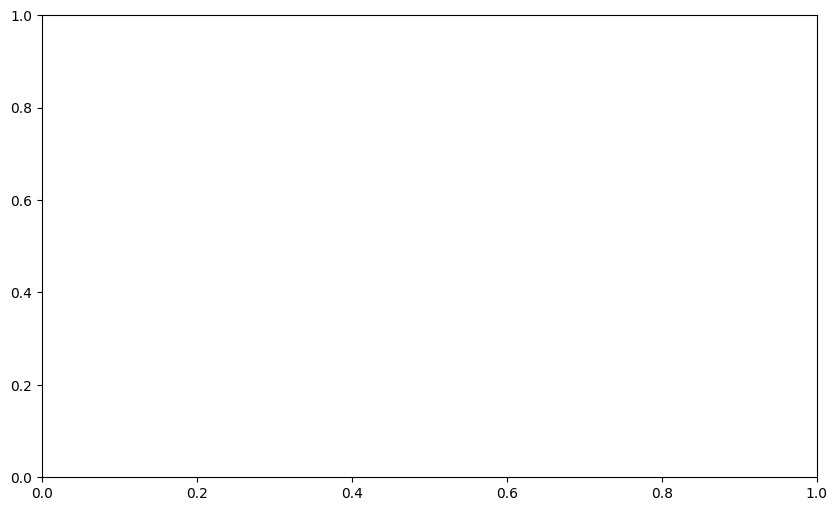

In [20]:
# 시각화 1: 피처 중요도 플롯
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), perm_importance.importances_mean, yerr=perm_importance.importances_std)
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

In [ ]:
# 시각화 2: ROC 곡선 플롯
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # 대각선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve.png')
plt.close()

In [ ]:
# 테스트 데이터 예측 및 제출 파일 생성
test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
submission = pd.DataFrame({'ID_code': test_data['ID_code'], 'target': test_pred_proba})
submission.to_csv('submission.csv', index=False)
print("제출 파일 'submission.csv'가 생성되었습니다.")